In [13]:
import squidpy as sq
import cellcharter as cc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import os
import glob
import scipy.sparse as sp
import scvi

In [14]:
# Clone13 adata
cl13_adata = sc.read_h5ad('/mnt/sata1/Dhruv_Analysis_1/2025_10_31_Clone13/combined/final_adata.h5ad')

cl13_adata.obs['Subtype'] = cl13_adata.obs['resolvi_predicted']

sc.pp.normalize_total(cl13_adata, target_sum=1e4)
sc.pp.log1p(cl13_adata)

cl13_adata.X

array([[5.025593 , 0.       , 0.       , ..., 4.9086304, 0.       ,
        0.       ],
       [5.5446796, 2.7721202, 0.       , ..., 5.351361 , 0.       ,
        0.       ],
       [4.935847 , 2.6073318, 0.       , ..., 5.3082924, 0.       ,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 4.2967925, 0.       , ..., 4.2967925, 0.       ,
        0.       ],
       [0.       , 5.027264 , 0.       , ..., 0.       , 0.       ,
        0.       ]], shape=(674090, 480), dtype=float32)

In [15]:
# Armstrong adata
arm_adata = sc.read_h5ad('/mnt/sata1/Dhruv_Analysis_1/spatial_paper_data/spatial_data_all_cells.h5ad')

arm_adata.X

array([[0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 2.8560932, ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ]], shape=(596928, 350), dtype=float32)

### Need to be using raw counts

In [16]:
arm_adata.layers['counts'] = arm_adata.layers['raw'].copy()
# now raw data stored in counts layer for both datasets

In [17]:
cl13_adata.obs["infection"] = "Clone13"
arm_adata.obs["infection"]  = "Armstrong"

# keep only shared genes so the model sees the same features
common = cl13_adata.var_names.intersection(arm_adata.var_names)
cl13_adata = cl13_adata[:, common].copy()
arm_adata  = arm_adata[:, common].copy()

adata = cl13_adata.concatenate(
    arm_adata,
    batch_key="infection",
    batch_categories=["Clone13", "Armstrong"],
    index_unique=None,   # keep original obs_names; change if collisions
    join="inner"
)


/tmp/ipykernel_2707813/3498633892.py:9: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata = cl13_adata.concatenate(


In [18]:
adata.X

array([[0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 3.2629168, 2.6073318, ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ]], shape=(1271018, 315), dtype=float32)

### Train joint Resolvi Model

In [ ]:
scvi.model.SCVI.setup_anndata(
    adata,
    layer="counts",
    batch_key="infection"  # this allows scVI to model dataset effect
)

model = scvi.model.SCVI(adata, n_latent=30, gene_likelihood="nb")
model.train(max_epochs=400, early_stopping=True)

adata.obsm["X_scVI"] = model.get_latent_representation()


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/400:   0%|          | 0/400 [00:00<?, ?it/s]

In [ ]:
model_dir = "/home/dpatravali/Desktop/IL-15_KO_Pipeline/figure_scripts/Dhruv_Clone13_Figures/models"

model.save(
    model_dir,
    overwrite=True,
    save_anndata=True   # IMPORTANT
)


### Cluster in joint latent space

In [ ]:
sc.pp.neighbors(adata, use_rep="X_scVI", n_neighbors=15)
sc.tl.leiden(adata, resolution=0.5)
sc.tl.umap(adata)


/tmp/ipykernel_1180128/2523296188.py:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=0.5)


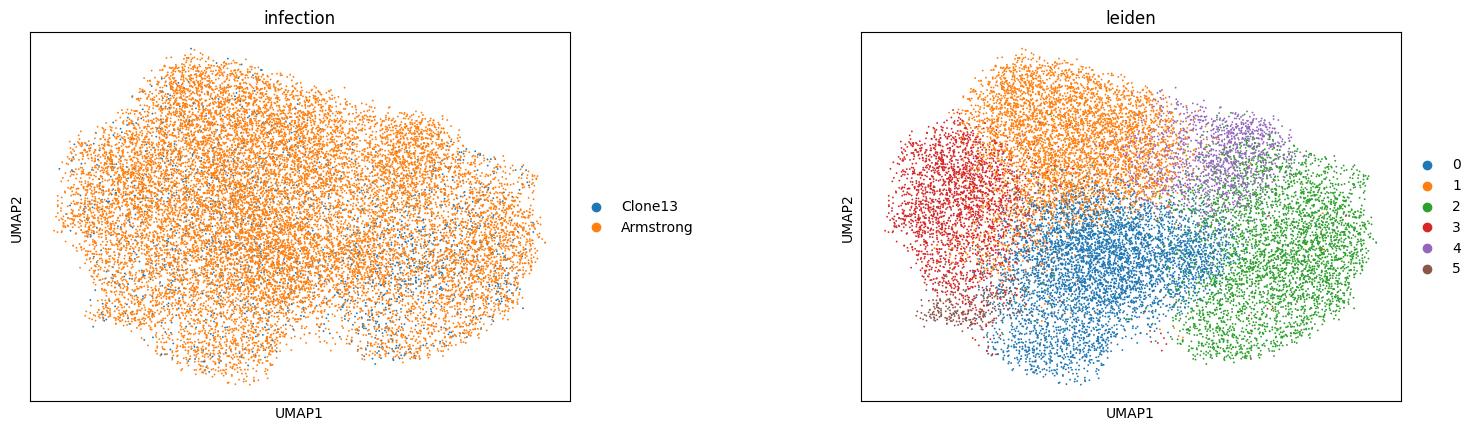

In [ ]:
sc.pl.umap(adata, color=["infection", "leiden"], wspace=0.4)


### Relative to population sizes

In [ ]:
p_global = adata.obs["infection"].value_counts(normalize=True)

counts = pd.crosstab(adata.obs["leiden"], adata.obs["infection"])
props  = counts.div(counts.sum(axis=1), axis=0)

# enrichment: how much more/less than global expectation
enrich = props.div(p_global, axis=1)   # >1 = enriched, <1 = depleted

display(props)
display(enrich)


infection,Clone13,Armstrong
leiden,,
0,0.094786,0.905214
1,0.087678,0.912322
2,0.176359,0.823641
3,0.085615,0.914385
4,0.055241,0.944759
5,0.105263,0.894737


infection,Clone13,Armstrong
leiden,,
0,0.893768,1.012603
1,0.826749,1.020553
2,1.662949,0.921352
3,0.807294,1.022861
4,0.520885,1.056839
5,0.992564,1.000882


In [ ]:
import pandas as pd

# counts per (cluster, infection_model)
counts = pd.crosstab(adata.obs["leiden"], adata.obs["infection"])

# normalize so each infection column sums to 1
props = counts.div(counts.sum(axis=0), axis=1)

# (optional) as percentages
props_pct = 100 * props

display(counts)
display(props.round(4))
display(props_pct.round(2))


infection,Clone13,Armstrong
leiden,,
0,449,4288
1,412,4287
2,649,3031
3,197,2104
4,78,1334
5,34,289


infection,Clone13,Armstrong
leiden,,
0,0.2468,0.2797
1,0.2265,0.2796
2,0.3568,0.1977
3,0.1083,0.1372
4,0.0429,0.0870
5,0.0187,0.0188


infection,Clone13,Armstrong
leiden,,
0,24.68,27.97
1,22.65,27.96
2,35.68,19.77
3,10.83,13.72
4,4.29,8.70
5,1.87,1.88


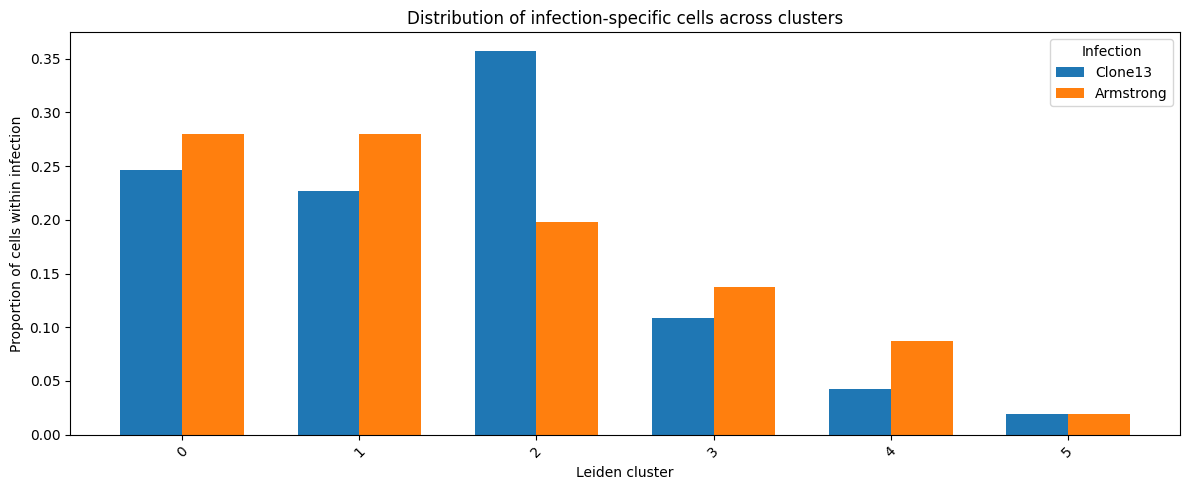

In [ ]:
# Use proportions (columns sum to 1)
plot_df = props.copy()        # or props_pct if you want %
clusters = plot_df.index.astype(str)
infections = plot_df.columns

x = np.arange(len(clusters))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 5))

for i, inf in enumerate(infections):
    ax.bar(
        x + i * width,
        plot_df[inf],
        width,
        label=inf
    )

ax.set_xlabel("Leiden cluster")
ax.set_ylabel("Proportion of cells within infection")
ax.set_title("Distribution of infection-specific cells across clusters")
ax.set_xticks(x + width / 2)
ax.set_xticklabels(clusters, rotation=45)
ax.legend(title="Infection")

plt.tight_layout()
plt.show()


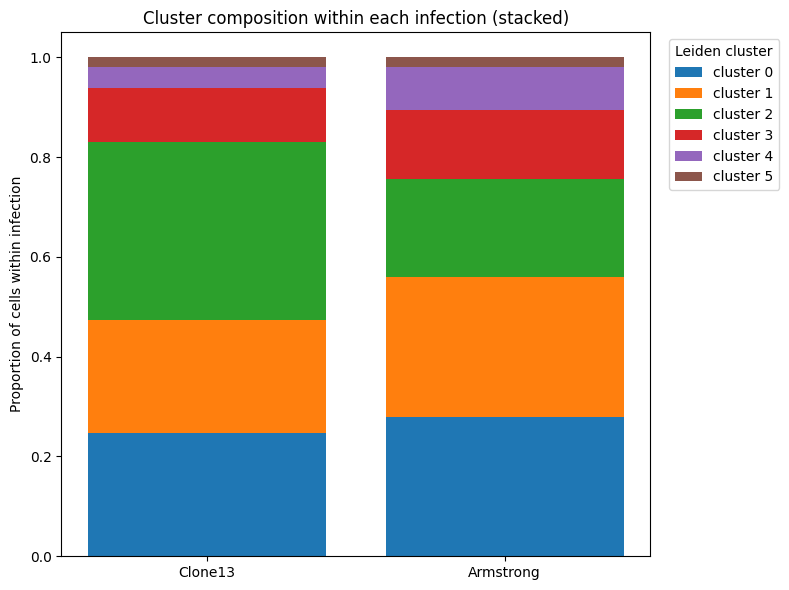

In [ ]:
# Choose proportions or percentages
plot_df = props.copy()        # columns sum to 1
# plot_df = props_pct.copy()  # columns sum to 100

# Optional: order clusters (e.g., numeric leiden)
plot_df = plot_df.loc[sorted(plot_df.index, key=lambda x: int(str(x)))]

infections = plot_df.columns.tolist()
clusters = plot_df.index.astype(str).tolist()

fig, ax = plt.subplots(figsize=(8, 6))

bottom = np.zeros(len(infections))

# Stack by cluster
for cl in clusters:
    vals = plot_df.loc[cl, infections].values
    ax.bar(infections, vals, bottom=bottom, label=f"cluster {cl}")
    bottom += vals

ax.set_ylabel("Proportion of cells within infection" if plot_df.max().max() <= 1 else "Percent of cells within infection")
ax.set_title("Cluster composition within each infection (stacked)")
ax.legend(title="Leiden cluster", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()


In [ ]:
# Ensure spatial coords exist (must be true before you can do neighborhoods later)
assert "X_spatial" in adata.obsm, "Missing adata.obsm['X_spatial']"

# Make a single sample key that combines infection + batch
# (batch should already exist in both datasets; if not, create it earlier)
adata.obs["sample_id"] = adata.obs["infection"].astype(str) + "__" + adata.obs["batch"].astype(str)

# Save everything needed for neighborhoods
out_path = "/mnt/sata1/Dhruv_Analysis_1/joint_cl13_armstrong_p14_ab_Xist_scvi_leiden.h5ad"
adata.write(out_path)
print("Wrote:", out_path)


Wrote: /mnt/sata1/Dhruv_Analysis_1/joint_cl13_armstrong_p14_ab_Xist_scvi_leiden.h5ad
